# Travelling Salesman Problem with subtour elimination
This example shows how to solve a TSP  by eliminating subtours using:
1) amplpy (defining the subtour elimination constraint in AMPL and instantiating it appropriately)
2) ampls (adding cuts directly from the solver callback)

In [1]:
# Import utilities
import os, sys
from math import floor, ceil
from __future__ import print_function

from amplpy import AMPL
import amplpy_gurobi as ampls

### Register jupyter magics for AMPL

In [2]:
from amplpy import register_magics
register_magics('_ampl_cells')  # Store %%ampl cells in the list _ampl_cells

Define TSP model in AMPL

In [3]:
%%ampl
set NODES ordered;
param hpos {NODES} >= 0;
param vpos {NODES} >= 0;

set PAIRS := {i in NODES, j in NODES: ord(i) < ord(j)};

param distance {(i,j) in PAIRS}
   := sqrt((hpos[j]-hpos[i])**2 + (vpos[j]-vpos[i])**2);

var X {PAIRS} binary;

minimize Tour_Length: sum {(i,j) in PAIRS} distance[i,j] * X[i,j];

subject to Visit_All {i in NODES}:
   sum {(i,j) in PAIRS} X[i,j] + sum {(j,i) in PAIRS} X[j,i] = 2;

AMPL data for TSP

In [4]:
%%ampl
data; 
param: NODES: hpos vpos :=
    N01  0 0
    N02  0 1
    N03  0 2
    N04  0 4
    N05  1 2
    N06  1 3
    N07  2 0
    N08  2 4
    N09  3 4
    N10  4 4
    N11  5 0
    N12  6 1
    N13  7 2
    N14  7 4
    N15  4 2
    N16  8 3
    N17  8 4;

Create AMPL object with amplpy and load model and data

In [5]:
tspAMPLModel = _ampl_cells[0]
tspAMPLData = _ampl_cells[1]
solver = "gurobi"
ampl = AMPL()
ampl.eval(tspAMPLModel)
ampl.eval(tspAMPLData)
ampl.option["solver"] = solver

# Set some globals that never change during the execution of the problem
NODES = set(ampl.getData("NODES").toList())
POINTS = ampl.getData("hpos,vpos").toList()
CPOINTS = {node: complex(x, y) for (node, x, y) in POINTS}

Define some helpers functions to plot the tours

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def plotTours(tours: list, points_coordinate: dict):
    # Plot all the tours in the list each with a different color
    colors = ['b', 'g', 'c', 'm', 'y', 'k']
    for i, tour in enumerate(tours):
        tourCoordinates = [points_coordinate[point.strip("'")] for point in tour]
        color = colors[i % len(colors)]
        plot_all(tourCoordinates, color = color)
    plt.show()

def plot_all(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], 's', alpha=alpha, color=color)
    
def plotline(points, style='o-', alpha=1, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    if color:
        plt.plot(X, Y, style, alpha=alpha, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha)
    
def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

Define some helper functions to help with the graphs (e.g. get the subtour given a set of arcs)

In [7]:
# Graphs helper routines
def trasverse(node, arcs: set, allnodes: set, subtour = None) -> list:
    # Trasverses all the arcs in the set arcs, starting from node
    # and returns the tour
    if not subtour:
        subtour = list()
    # Find arcs involving the current node
    myarcs = [(i,j) for (i,j) in arcs if node == i or node == j]
    if len(myarcs) == 0:
        return 
    # Append the current node to the current subtour
    subtour.append(node)

    # Use the first arc found
    myarc = myarcs[0]
    # Find destination (or origin) node
    destination = [(i) for i in myarc if i != node][0]
    # Remove from arcs and nodes to visit
    arcs.remove(myarc)
    allnodes.remove(node)

    trasverse(destination, arcs, allnodes, subtour)
    return subtour


def findSubTours(arcs: set, allnodes: set):
    """Find all the subtours defined by a set of arcs and
       return them as a list of list
    """
    subtours = list()
    while len(allnodes) > 0:
        l = trasverse(next(iter(allnodes)), arcs, allnodes)
        subtours.append(l)
    return subtours

AMPLPY implementation of sub-tours elimination

In [8]:
def amplSubTourElimination(ampl: AMPL):
    # Add the constraint and the needed parameters
    subToursAMPL = """param nSubtours >= 0 integer, default 0;
    set SUB {1..nSubtours} within NODES;

    subject to Subtour_Elimination {k in 1..nSubtours}:
    sum {i in SUB[k], j in NODES diff SUB[k]} 
    if (i,j) in PAIRS then X[i,j] else X[j,i] >= 2;"""
    ampl.eval(subToursAMPL)

    AMPLnSubtours = ampl.getParameter("nSubtours")
    AMPLSubtours = ampl.getSet("SUB")

    allsubtours = list()
    while True: # Repeat until the solution contains only one tour
        ampl.solve()
        # Get solution
        ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j]>0} X[i,j];")
        ARCS = set([(i,j) for (i,j,k)in ARCS.toList()])
        nodes = NODES.copy()
        subtours = findSubTours(ARCS, nodes)
        # If we have only one tour, the solution is valid
        if len(subtours) <= 1:
            break
        print(f"Found {len(subtours)} subtours, plotting them and adding cuts")
        plotTours(subtours, CPOINTS)
        # Else add the current tours to the list of subtours
        allsubtours.extend(subtours)
        # And add those to the constraints by assigning the values to
        # the parameter and the set
        AMPLnSubtours.set(len(allsubtours))
        for (i, tour) in enumerate(allsubtours):
            AMPLSubtours[i+1].setValues(tour)

ampls callbacks implementation of subtours elimination

In [9]:
# Callback class that actually add the cuts if subtours are found in a solution
class MyCallback(ampls.GenericCallback):
    def run(self):
        try:
            # For each solution
            if self.getAMPLWhere() == ampls.Where.MIPSOL:
                print("Found one solution")
                sol = self.getSolutionVector()
                arcs = [xvars[i] for i,value in enumerate(sol) if value > 0]
                subTours = findSubTours(set(arcs), set(vertices))
                if len(subTours) ==1:
                    print("No subtours detected. Ending optimization.")
                    return 0
                print(f"Found {len(subTours)} subtours, plotting them and adding cuts")
                plotTours(subTours, CPOINTS)
                for subTour in subTours:
                    st1 = set(subTour)
                    nst1 = set(vertices) - st1
                    externalArcs = [(i,j) if i < j else (j,i) for i in st1 for j in nst1]
                    varsExternalArcs = [xinverse[(i,j)] for (i,j) in externalArcs]
                    coeffs = [1 for i in range(len(varsExternalArcs))]
                    varsExternalArcs = sorted(varsExternalArcs)
                    print("Adding cut for subtour")
                    self.addLazyIndices(varsExternalArcs , coeffs, ampls.CutDirection.GE, 2)
                if len(subTours) == 2: # do not add the second subtour if we have only 2
                    return 0
            return 0
        except Exception as e:
            print('Error:', e)
            return 1


In [10]:

# Global variables to store entities needed by the callbacks
# that never change
xvars = None
xinverse = None
vertices = None
def solverSubTourElimination(ampl: AMPL, solver):
    global xvars, xinverse, vertices
    # Export the model using ampls
    model = ampl.exportModel(solver)
    model.enableLazyConstraints()

    # Get the global maps between solver vars and AMPL entities
    varMap = model.getVarMapFiltered("X")
    inverse = model.getVarMapInverse()
    xvars = {index: ampls.var2tuple(var)[1:] for var, index in varMap.items()}
    xinverse = {ampls.var2tuple(var)[1:]: index for index, var in inverse.items()}
    vertices = list(sorted(set([x[0] for x in xvars.values()] + [x[1] for x in xvars.values()])))

    # Assign the callback
    callback = MyCallback()
    model.setCallback(callback)
    print("Start optimization")
    # Start the optimization
    model.optimize()
    # Import the solution back to AMPL
    ampl.importSolution(model)

Script running the optimization

Start optimization
Found one solution
Found 3 subtours, plotting them and adding cuts


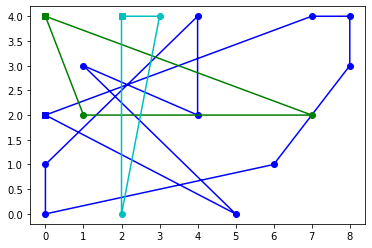

Adding cut for subtour
Adding cut for subtour
Adding cut for subtour
Found one solution
Found 5 subtours, plotting them and adding cuts


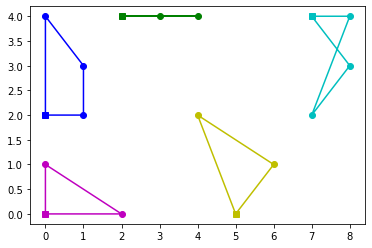

Adding cut for subtour
Adding cut for subtour
Adding cut for subtour
Adding cut for subtour
Adding cut for subtour
Found one solution
Found 4 subtours, plotting them and adding cuts


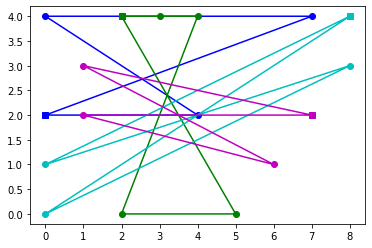

Adding cut for subtour
Adding cut for subtour
Adding cut for subtour
Adding cut for subtour
Found one solution
Found 3 subtours, plotting them and adding cuts


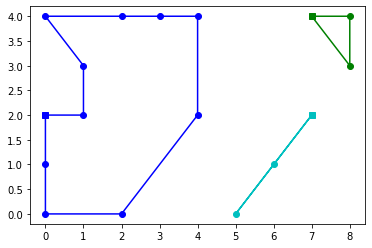

Adding cut for subtour
Adding cut for subtour
Adding cut for subtour
Found one solution
No subtours detected. Ending optimization.
Gurobi 9.0.3: optimal solution; objective 25.72134935173836
28 simplex iterations
No dual variables returned.


In [11]:
# Set to true to use AMPL, False to use solver callbacks
doAMPL = False
if doAMPL:
    amplSubTourElimination(ampl)
else:
    solverSubTourElimination(ampl, solver)

Get the solution, print it and display it

{'N14', 'N03', 'N05', 'N11', 'N16', 'N04', 'N07', 'N10', 'N15', 'N08', 'N17', 'N06', 'N01', 'N13', 'N02', 'N09', 'N12'}
{('N07', 'N15'), ('N04', 'N08'), ('N13', 'N16'), ('N01', 'N07'), ('N14', 'N17'), ('N11', 'N15'), ('N11', 'N12'), ('N02', 'N03'), ('N04', 'N06'), ('N12', 'N13'), ('N09', 'N10'), ('N05', 'N06'), ('N01', 'N02'), ('N10', 'N14'), ('N03', 'N05'), ('N08', 'N09'), ('N16', 'N17')}
Calling plottours


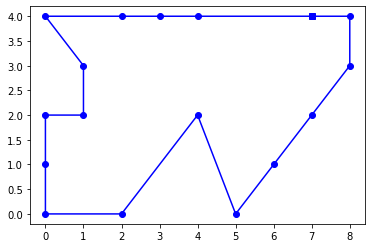

In [12]:
# Get the solution into ARCS
ARCS = ampl.getData("{(i,j) in PAIRS : X[i,j]>0} X[i,j];")
ARCS = set([(i,j) for (i,j,k) in ARCS.toList()])
# Print it
print(NODES)
print(ARCS)
# Display it
tours = findSubTours(ARCS, NODES)
print("Calling plottours")
plotTours(tours, CPOINTS)

In [13]:
print(NODES)

set()
